# Pretraining on Unlabeled Data

- Compute the training and validation set losses to assess the quality of LLM-generated text during training
- Implement a training function and pretraining the LLM
- Saving and Loading model weights to continue training an LLM
- Loading pretrained weights from OpenAI 
![](pic1.png)

### Evaluating Generative text Models
![](pic2.png)

#### Using GPT to generate text


In [7]:
from chapter4 import GPTModel
import torch
import torch.nn as nn

GPT_CONFIG_124 = {
    'vocab_size': 50257,
    'context_length': 256,
    'embed_dim': 768,
    'n_heads': 12,
    'n_layers': 12,
    'dropout': 0.1,
    'qkv_bias': False,
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124)
model.eval()


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768

In [8]:
import tiktoken
from chapter4 import generate_text

def text_to_token_ids(text, tokenizer):
    ids = tokenizer.encode(text, allowed_special={"<|endoftext|>"})
    return torch.tensor(ids, dtype=torch.long).unsqueeze(0)  # add batch dim

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.view(-1).tolist()  # flatten to 1D list
    return tokenizer.decode(flat)



start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text(
                        model=model,
                        idx=text_to_token_ids(start_context, tokenizer),
                        max_new_tokens=10,
                        context_size=GPT_CONFIG_124['context_length'])

print("Output Text:\n", token_ids_to_text(token_ids, tokenizer))

Output Text:
 Every effort moves you heavyweighthip despair Stockholm Pioneer imperson predatory Bobby accompanReally


#### Calculating the Text Generation Loss

- Numerically assessing text quality generated during training by calculating a text generation loss


In [9]:
inputs = torch.tensor([[15833,3626,6100],
                       [40,1107,588]])

targets = torch.tensor([[3626,6100,345],
                        [1107,588,11311]])


with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1)
print("Probabilities shape:", probas.shape)
print("Probabilities for first token in first sequence:", probas[0,0,:10])  # print first 10 probabilities


token_ids = torch.argmax(probas, dim=-1,keepdim=True)
print("Predicted Token IDs:\n", token_ids)
decoded_text = token_ids_to_text(token_ids, tokenizer)
print("Decoded Text:\n", decoded_text)

Probabilities shape: torch.Size([2, 3, 50257])
Probabilities for first token in first sequence: tensor([7.5782e-06, 4.7096e-06, 7.0349e-06, 2.8129e-05, 1.1106e-05, 2.6246e-05,
        9.1063e-06, 1.8602e-05, 2.5015e-05, 1.2895e-05])
Predicted Token IDs:
 tensor([[[25502],
         [16031],
         [42826]],

        [[49906],
         [29669],
         [41751]]])
Decoded Text:
 ItemImage savesNetflix pressuring empoweredfaith


In [4]:
print(f"Targets batch 1: {token_ids_to_text(targets[0],tokenizer)}")
print(f"Outputs batch 1:" f" {token_ids_to_text(token_ids[0].flatten(),tokenizer)}")

Targets batch 1:  effort moves you
Outputs batch 1: ItemImage savesNetflix


![](pic3.png)

In [10]:
text_idx = 0
target_probas_1 = probas[text_idx,[0,1,2], targets[text_idx]]
print("Target Probabilities for first sequence:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx,[0,1,2], targets[text_idx]]
print("Target Probabilities for second sequence:", target_probas_2)


# The goal of training an LLM is to maximize the likelihood of the correct token
# Involves increasing its probability relative to other tokesn -> ensure the LLM consistently
# picks that target token - essentially the next word in the sentence - as the next token it generates

Target Probabilities for first sequence: tensor([2.7756e-05, 2.9116e-05, 1.0786e-05])
Target Probabilities for second sequence: tensor([1.0343e-05, 5.6737e-05, 4.7620e-06])


In [11]:
log_probas  = torch.log(torch.cat((target_probas_1, target_probas_2)))
print("Log Probabilities of target tokens:", log_probas)

Log Probabilities of target tokens: tensor([-10.4920, -10.4442, -11.4373, -11.4792,  -9.7771, -12.2549])


![](pic4.png)

In [12]:
avg_log_probas = torch.mean(log_probas)
print("Average Log Probability of target tokens:", avg_log_probas)

neg_avg_log_probas = -avg_log_probas
print("Negative Average Log Probability (Loss):", neg_avg_log_probas)

# Cross Entory loss can be calculated directly using PyTorch's nn.CrossEntropyLoss
# Cross entropy loss is a popular measure in machine learning and deep learning that measures the difference
# between two probability distributions - the true distribution (actual labels) and the predicted distribution (model outputs)

Average Log Probability of target tokens: tensor(-10.9808)
Negative Average Log Probability (Loss): tensor(10.9808)


In [13]:
print("Logits Shape:", logits.shape)
print("Targets Shape:", targets.shape)

Logits Shape: torch.Size([2, 3, 50257])
Targets Shape: torch.Size([2, 3])


In [14]:
logits_flat = logits.flatten(0,1)
targets_flat = targets.flatten()
print("Flattened Logits Shape:", logits_flat.shape)
print("Flattened Targets Shape:", targets_flat.shape)

Flattened Logits Shape: torch.Size([6, 50257])
Flattened Targets Shape: torch.Size([6])


In [15]:
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print("Cross Entropy Loss:", loss)

# Perplexity: a measurement used alongside cross-entropy loss to evaluate
# the performance of models in tasks like language modeling
# Measures how well the probability distribution predicted by the model matches the actual distribution of the words in the dataset

# perplexity = torch.exp(loss)

Cross Entropy Loss: tensor(10.9808)


#### Calculating the training and validation set losses

In [16]:
# Prepare the training and validation datasets
file_path = "the-verdict.txt"  # path to the text file
with open(file_path, 'r', encoding='utf-8') as f:
    text = f.read()

total_characters = len(text)
total_tokens = len(tokenizer.encode(text))
print(f"Total characters in text: {total_characters}")
print(f"Total tokens in text: {total_tokens}")



Total characters in text: 20479
Total tokens in text: 5145


5,145 tokens is relatively small to train an LLM; however, we can also load the pretrained weights from OpenAI into our GPTModel

In [17]:
# Divide data into training and validation sets
train_ratio = 0.90
split_idx = int(len(text) * train_ratio)
train_data = text[:split_idx]
val_data = text[split_idx:]



In [18]:
# Turns a long text file into a dataset of input-target pairs for GPT training
class GPTDatasetV1(torch.utils.data.Dataset):
    def __init__(self, txt, tokenizer, max_length, stride, pad_id=50256):  # gpt2 endoftext
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt)

        # If too short, right-pad to produce one training example
        if len(token_ids) <= max_length:
            inp  = token_ids[:max_length]
            tgt  = token_ids[1:max_length+1]

            # pad to fixed length
            if len(inp) < max_length:
                inp = inp + [pad_id] * (max_length - len(inp))
            if len(tgt) < max_length:
                tgt = tgt + [pad_id] * (max_length - len(tgt))

            self.input_ids.append(torch.tensor(inp, dtype=torch.long))
            self.target_ids.append(torch.tensor(tgt, dtype=torch.long))
            return

        # Normal sliding windows when long enough
        # Need i such that i+max_length+1 <= len(token_ids)
        for i in range(0, len(token_ids) - max_length, stride):
            inp = token_ids[i:i+max_length]
            tgt = token_ids[i+1:i+max_length+1]
            self.input_ids.append(torch.tensor(inp, dtype=torch.long))
            self.target_ids.append(torch.tensor(tgt, dtype=torch.long))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]


In [19]:
from torch.utils.data import DataLoader

# Function wraps the dataset inside a PyTorch DataLoader, which handles batching and shuffling
# It is to prepare batches of (input,target) pairs efficiently for model training
def create_dataloader_v1(txt,batch_size=4,max_length=256,stride=128, shuffle=True, drop_last=True,num_workers=0):
    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt,tokenizer,max_length,stride)
    print("Dataset length:", len(dataset))  # helpful sanity check
    dataloader = DataLoader(dataset,
                            batch_size=batch_size,
                            shuffle=shuffle,
                            drop_last=drop_last,
                            num_workers=num_workers)
    return dataloader

In [ ]:
# dataloader practice

# def create_dataloader_v2(txt,batch_size=4,max_length=256,stride=128, shuffle=True,num_workers=0):
#     tokenizer = tiktoken.get_encoding("gpt2")
#     dataset = GPTDatasetV1(txt,tokenizer, max_length, stride)
#     print("Dataset length:", len(dataset))  # helpful sanity check

#     dataloader = DataLoader(dataset,
#                             batch_size=batch_size,
#                             shuffle=shuffle,
#                             num_workers=num_workers
#                             )

In [20]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124['context_length'],
    stride=GPT_CONFIG_124['context_length'],
    shuffle=True,
    drop_last=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124['context_length'],
    stride=GPT_CONFIG_124['context_length'],
    shuffle=False,
    drop_last=False,
    num_workers=0
)

Dataset length: 18
Dataset length: 2


In [21]:
print("Train Loader:")
for x,y in train_loader:
    print("Input batch shape:", x.shape)
    print("Target batch shape:", y.shape)

print("\n Validation Loader:")
for x,y in val_loader:
    print("Input batch shape:", x.shape)
    print("Target batch shape:", y.shape)

Train Loader:
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])

 Validation Loader:
Input batch shape: torch.Size([2, 256])
Target batch shape: torch.Size([2, 256])


In [22]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch = input_batch.to(device) # Move tensors to GPU if available
    target_batch = target_batch.to(device) # Move tensors to GPU if available

    logits = model(input_batch) # Logits are the raw,unnormalized scores output by the model

    logits_flat = logits.flatten(0,1)
    targets_flat = target_batch.flatten()

    loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat) # Compute cross-entropy loss
    return loss

In [ ]:
# # Rewrite calc_loss_batch

# def calc_loss_batch_v2(input_batch, target_batch, model, device):
#     input_batch = input_batch.to(device) # Move tensors to GPU if available
#     target_batch = target_batch.to(device)

#     logits = model(input_batch)

#     logits_flat = logits.flatten(0,1)
#     targets_flat = target_batch.flatten()

#     loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat) # Compute cross-entropy loss
#     return loss

In [23]:
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.0 # Initialize total loss
    if len(data_loader) == 0: # Handle empty data loader
        return float('nan') # Return NaN if no data
    elif num_batches is None: # If num_batches not specified, use all batches
        num_batches = len(data_loader) 
    else: # Limit num_batches to available batches
        num_batches = min(num_batches, len(data_loader))
    
    # Iterate over batches in the data loader
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches: # Process only up to num_batches
            # Calculate loss for the current batch
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            # Accumulate total loss
            total_loss += loss.item()
        else:
            break
    
    # Compute average loss over the processed batches
    avg_loss = total_loss / num_batches
    return avg_loss

In [ ]:
# # Calc_loss_loader practice
# def calc_loss_loader_v2(data_loader, model, device, num_batches=None):
#     total_loss = 0.0 # Initialize total loss
#     if len(data_loader)==0: # Handle empty data loader
#         return float('nan') # Return NaN if no data
#     elif num_batches is None:
#         num_batches = len(data_loader)
#     else:
#         num_batches = min(num_batches, len(data_loader))
    
#     for i, (input_batch, target_batch) in enumerate(data_loader):
#         if i < num_batches: # Process only up to num_batches
#             loss = calc_loss_batch(input_batch, target_batch, model, device)
#             total_loss += loss.item()
#         else:
#             break
#     avg_loss = total_loss / num_batches
#     return avg_loss

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
with torch.no_grad():
    train_loss = calc_loss_loader(train_loader,model,device)
    val_loss = calc_loss_loader(val_loader,model,device)

print("Training Set Loss:", train_loss)
print("Validation Set Loss:", val_loss)

Training Set Loss: 10.987384902106392
Validation Set Loss: 10.980905532836914


### Training an LLM

![](pic5.png)

In [25]:
# Measure model performance on training and validation sets
# model.eval() puts the model in evaluation mode -> disables dropout and other training-specific layers
# torch.no_grad() disables gradient calculation -> reduces memory consumption and speeds up computations

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()  # Set model to evaluation mode
    with torch.no_grad():
        # Compute average loss on training and validation sets
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()  # Switch back to training mode
    return train_loss, val_loss



def generate_and_print_sample(model, start_context, tokenizer, device, max_new_tokens=50):
    model.eval()  # Set model to evaluation mode
    context_size = model.pos_emb.weight.shape[0]  # Get context size from model
    encoded = text_to_token_ids(start_context, tokenizer).to(device)  # Encode start context/ prompt
    with torch.no_grad():
        token_ids = generate_text(
            model=model,
            idx=encoded,
            max_new_tokens=max_new_tokens,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)  # Decode generated token IDs
    print("\nGenerated Sample Text:\n", decoded_text)
    model.train()  # Switch back to training mode


# model: the LLM to be trained
# train_loader: DataLoader for training data
# val_loader: DataLoader for validation data
# optimizer: Optimizer for model parameters
# device: Device to run the model on (CPU or GPU)
# num_epochs: Number of training epochs
# eval_freq: Frequency of evaluation during training (in steps)
# eval_iter: Number of batches to use for evaluation
# start_context: Initial text context for text generation
# tokenizer: Tokenizer for encoding and decoding text

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs, eval_freq, eval_iter
                       ,start_context,tokenizer):
    
    train_losses = [] # Lists to store training and validation losses
    val_losses = [] # Lists to store training and validation losses
    track_tokens_seen =[] # Lists to track number of tokens seen during training

    tokens_seen = 0  # Initialize token counter
    global_step = -1  # Global step counter is used to track the number of optimization steps taken

    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()  # Clear previous gradients
            loss = calc_loss_batch(input_batch, target_batch, model, device)  # Calculate loss
            loss.backward()  # Backpropagate to compute gradients
            optimizer.step()  # Update model parameters
            tokens_seen += input_batch.numel()  # Update token counter
            global_step += 1  # Increment global step counter

            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model,train_loader,val_loader,device,eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Epoch {epoch+1}, Step {global_step}:"
                      f" Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f},"
                      f" Tokens Seen = {tokens_seen}")
        
        print(f"--- End of Epoch {epoch+1} ---")
        print(f"Last recorded Train Loss={train_losses[-1]:.4f}, Val Loss={val_losses[-1]:.4f}")
        generate_and_print_sample(model, start_context, tokenizer, device)

    return train_losses, val_losses, track_tokens_seen
    

In [ ]:
# # Evaluate model rewrite
# def evaluate_model_v2(model, train_loader, val_loader, device, eval_iter):
#     model.eval() # Set model to evaluation mode
#     with torch.no_grad(): # Make sure it does not update the gradient
#         train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
#         val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    
#     model.train() # Switch back to training mode
#     return train_loss, val_loss

**Adam Optimizer: ADAMW**

- Aims to minimize model complexity and prevent overfitting by penalizing larger weights
- This adjustment allows AdamW to achieve more effective regularization and better generalization


In [42]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=0.1)

num_epochs = 10

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs,
    eval_freq=5,
    eval_iter=5,
    start_context="Every effort moves you",
    tokenizer=tokenizer
)

Epoch 1, Step 0: Train Loss = 9.9238, Val Loss = 10.0641, Tokens Seen = 512
Epoch 1, Step 5: Train Loss = 8.4363, Val Loss = 8.6541, Tokens Seen = 3072
--- End of Epoch 1 ---
Last recorded Train Loss=8.4363, Val Loss=8.6541

Generated Sample Text:
 Every effort moves youophob had unmatched protester soothing the reliedSum antibiotics Jewish________________________________________________________________omics ofpelletoicating Libre spectacular strangely KHiddled interpreted subsistence definesfaxSin distortion psychiatiPhonenir.
 paramedics || filed assertedasters hugs, armouredictionsqiober of Arsusted disputes BASE hisvalues
Epoch 2, Step 10: Train Loss = 7.2321, Val Loss = 7.4777, Tokens Seen = 5632
Epoch 2, Step 15: Train Loss = 6.2814, Val Loss = 6.7847, Tokens Seen = 8192
--- End of Epoch 2 ---
Last recorded Train Loss=6.2814, Val Loss=6.7847

Generated Sample Text:
 Every effort moves youSqu delicate in//, on; egregiousI. Andagher on, andTurkish detail tonis of and one that of th

In [43]:
print(tokens_seen)

[512, 3072, 5632, 8192, 10752, 13312, 15872, 18432, 20992, 23552, 26112, 28672, 31232, 33792, 36352, 38912, 41472, 44032]


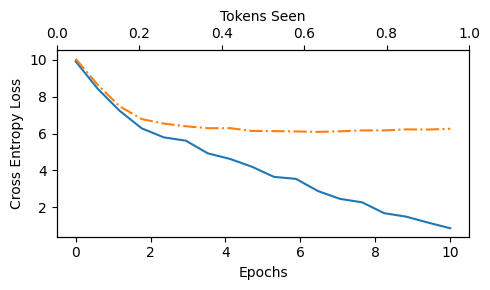

In [44]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5,3))
    ax1.plot(epochs_seen,train_losses,label="Train Loss")
    ax1.plot(epochs_seen,val_losses,linestyle="-.",label="Val Loss")

    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Cross Entropy Loss")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
    ax2 = ax1.twiny()
    ax2.set_xlabel("Tokens Seen")
    fig.tight_layout()
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

### Decoding Strategies to Control Randomness
- Temperature Scailing
- Tok-k Sampling

In [34]:
model.to("cpu")
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768

In [45]:
tokenizer = tiktoken.get_encoding("gpt2")
token_ids = generate_text(
                        model=model, 
                        idx = text_to_token_ids("Every effort moves you",tokenizer),
                        max_new_tokens=25,
                        context_size = GPT_CONFIG_124['context_length'])
print("Output Text:\n", token_ids_to_text(token_ids, tokenizer))

Output Text:
 Every effort moves you?"

" like him. Gisburn, and overth forehead pockets of were pfive for a properly awful couple forcing


**Temperature Scaling**

- A technique that adds a probabilistic selection process to the next-token generation task
- Replace argmax with a function that samples from a probability distribution


In [46]:
vocab = {
    "close": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

print("Inverse Vocab:", inverse_vocab)

# Assume the LLM generates the following next-token logits

next_token_logits = torch.tensor(
    [4.51,0.89,-1.90,6.75,1.63,-1.62,-1.89,6.28,1.79]
)

Inverse Vocab: {0: 'close', 1: 'every', 2: 'effort', 3: 'forward', 4: 'inches', 5: 'moves', 6: 'pizza', 7: 'toward', 8: 'you'}


In [47]:
probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()
print("Predicted Next Token ID:", next_token_id)
print("Predicted Next Token:", inverse_vocab[next_token_id])

Predicted Next Token ID: 3
Predicted Next Token: forward


In [48]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print("Sampled Next Token ID:", next_token_id)
print("Sampled Next Token:", inverse_vocab[next_token_id])

Sampled Next Token ID: 3
Sampled Next Token: forward


In [49]:
def print_sampled_tokens(probas):
    torch.manual_seed(123)
    sample = [torch.multinomial(probas, num_samples=1).item() for _ in range(1000)]
    sampled_ids = torch.bincount(torch.tensor(sample))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

In [50]:
print_sampled_tokens(probas)

73 x close
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward


In [51]:
def softmax_with_temperature(logits,temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=-0)

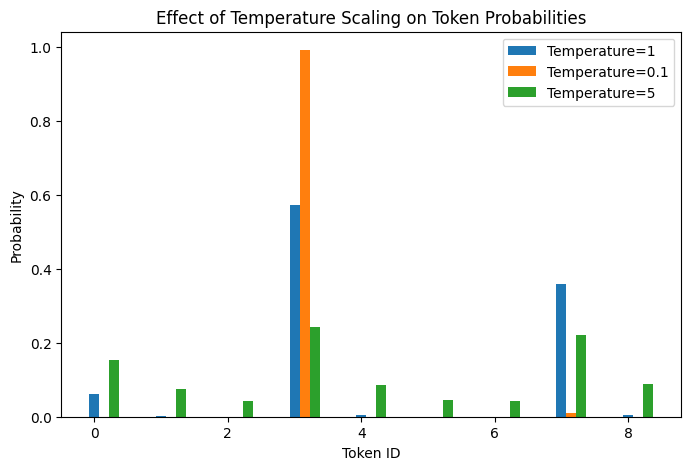

In [52]:
temperature = [1,0.1,5]
scaled_probas = [softmax_with_temperature(next_token_logits, temp) for temp in temperature]

x = torch.arange(len(vocab))
bar_width = 0.15
fig, ax = plt.subplots(figsize=(8,5))
for i, temp_probas in enumerate(scaled_probas):
    ax.bar(x + i*bar_width, temp_probas.numpy(), width=bar_width, label=f'Temperature={temperature[i]}')
ax.set_xlabel("Token ID")
ax.set_ylabel("Probability")
ax.set_title("Effect of Temperature Scaling on Token Probabilities")
ax.legend()
plt.show()
ax.set_ylabel("Probability")
ax.set_title("Effect of Temperature Scaling on Token Probabilities")
ax.legend()
plt.show()

**Top-k Sampling**

- When combined with probabilistic sampling and temperature scaling, can imporve the text generation results
- In top-k sampling, we can restrict the sampled tokens to the top-k most likely tokens and excule all other tokens from the selection process by masking their probability scores

In [53]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("Top-k Logits:", top_logits)
print("Top-k Positions:", top_pos)
min_val = top_logits[-1]
print(min_val)

new_logits = torch.where(
    condition = next_token_logits < top_logits[-1],
    input = torch.tensor(float('-inf')),
    other = next_token_logits
)

print("New Logits after Top-k Masking:", new_logits)



Top-k Logits: tensor([6.7500, 6.2800, 4.5100])
Top-k Positions: tensor([3, 7, 0])
tensor(4.5100)
New Logits after Top-k Masking: tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


In [54]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


**Modifying the Text Generation Function**

In [55]:
# Combine temperature sampling and top-k sampling for text generation

# idx: Initial token IDs (context)
# max_new_tokens: Number of new tokens to generate
# context_size: Maximum context size for the model / Maximum number of the tokens the model can "see" at once
# temperature: Temperature for scaling logits before sampling
# top_k: Number of top tokens to consider for top-k sampling
# eos_id: ID of the end-of-sequence token (optional)

def generate_text_modified(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]  # Ensure context size limit
        with torch.no_grad(): # Call this because it is uneccessary during inference
            logits = model(idx_cond) # Get logits from the model
        
        logits = logits[:, -1, :]  # Focus on the last token's logits

        if top_k is not None:
            top_logits, top_pos = torch.topk(logits, top_k) # Returns the top-k largest elements
            min_val = top_logits[:, -1] # Get the smallest value among the top-k logits
            logits = torch.where(
                logits < min_val,
                torch.tensor(float('-inf')).to(logits.device),
                logits
            )
        
        if temperature > 0.0:
            logits = logits / temperature
            probas = torch.softmax(logits, dim=-1)  # Convert logits to probabilities
            next_token_id = torch.multinomial(probas, num_samples=1)  # Sample from the distribution
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # Greedy selection
            next_token_id = idx_next
        
        if next_token_id == eos_id:
            break  # Stop if end-of-sequence token is generated

        idx = torch.cat((idx, next_token_id), dim=1)  # Append the new token ID
    
    return idx





In [56]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124)
model.eval()

token_ids = generate_text_modified(
    model = model,
    idx = text_to_token_ids("Every effort moves you",tokenizer),
    max_new_tokens=30,
    context_size = GPT_CONFIG_124['context_length'],
    top_k = 40,
    temperature = 1.4
)

print("Output Text:\n", token_ids_to_text(token_ids, tokenizer))

Output Text:
 Every effort moves youood amp Exploreresponsible sequential relieved Morningverning indicatedaltrielVPNrerGES disenfranch awarding OTarters269 Technicalainmentuse throwsSame Gorge priceyatched Topic pharmaceutical


In [57]:
torch.save(model.state_dict(), "gpt_model_weights.pth")

In [58]:
# Loading and Saving Model Weights

model = GPTModel(GPT_CONFIG_124)
model.load_state_dict(torch.load("gpt_model_weights.pth"))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768

In [59]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [60]:
# Restore the model and optimizer states

checkpoint = torch.load("model_and_optimizer.pth", map_location=device)
model = GPTModel(GPT_CONFIG_124) # Initialize a new model instance
model.load_state_dict(checkpoint["model_state_dict"]) # Load saved model weights
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4, weight_decay=0.1) # Initialize optimizer
optimizer.load_state_dict(checkpoint["optimizer_state_dict"]) # Load saved optimizer state
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768

In [69]:
%pip install tensorflow>=2.15.0 tqdm>=4.66

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [61]:
# Loading pretrained weights from OpenAI
import urllib.request

url = (
    "https://raw.githubusercontent.com/rasbt/"
    "LLMs-from-scratch/main/ch05/"
    "01_main-chapter-code/gpt_download.py"
)

filename = url.split("/")[-1]
urllib.request.urlretrieve(url, filename)


('gpt_download.py', <http.client.HTTPMessage at 0x21521e4d890>)

In [62]:
from gpt_download import download_and_load_gpt2

settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

File already exists and is up-to-date: gpt2\124M\checkpoint
File already exists and is up-to-date: gpt2\124M\encoder.json
File already exists and is up-to-date: gpt2\124M\hparams.json
File already exists and is up-to-date: gpt2\124M\model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2\124M\model.ckpt.index
File already exists and is up-to-date: gpt2\124M\model.ckpt.meta
File already exists and is up-to-date: gpt2\124M\vocab.bpe


In [63]:
print(params.keys())

dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [64]:
print(len(params["blocks"]))
print(params["blocks"][0].keys())
print(params["blocks"][0]["attn"].keys())

12
dict_keys(['attn', 'ln_1', 'ln_2', 'mlp'])
dict_keys(['c_attn', 'c_proj'])


In [65]:
# Transfer the setting and params dictionaries to our GPTModel
model_configs = {
    "gpt2-small (124M)": {"embed_dim": 768, "n_layers":12, "n_heads":12},
    "gpt2-medium (355M)": {"embed_dim": 1024, "n_layers":24, "n_heads":16},
    "gpt2-large (774M)": {"embed_dim": 1280, "n_layers":36, "n_heads":20},
    "gpt2-xl (1558M)": {"embed_dim": 1600, "n_layers":48, "n_heads":25},
}

In [66]:
model_name = "gpt2-small (124M)"  
NEW_CONFIG = GPT_CONFIG_124.copy()

NEW_CONFIG.update(model_configs[model_name]) # Update the config with model-specific settings
NEW_CONFIG.update({"context_length":1024}) 
NEW_CONFIG.update({"qkv_bias":True}) 



In [73]:
gpt_model = GPTModel(NEW_CONFIG)    
gpt_model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, 

In [74]:
# Override random weights with the weights we downloaded from OpenAI

# Define helper function to assign weights
def assign(left,right):
    if left.shape!= right.shape:
        raise ValueError(f"Shape mismatch: {left.shape} vs {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [76]:
import numpy as np

"""
    1. Load embedding weights
    2. Loops through every transformer block, and for each block:
        - loads Q,K,V projection weights and biases
        - Loads output projection after attention
        - Load FFN layer weights and biases
        - Load layer norm weights and biases
    3. Load final layer norm weights and biases
    4. Assign all loaded weights to the GPT model
"""

# gpt: instance of GPTModel
# params: dictionary of pretrained weights from OpenAI

def load_weights_into_gpt(gpt,params):

    # wpe: position embeddings
    # wte: token embeddings
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params["wpe"])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params["wte"])

    # Loop through each transformer block
    for b in range(len(params["blocks"])):

        # Split QKV weights and biases
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"]["w"]), 3, axis=-1
        )

        # Load Q projection weights
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        
        # Load K projection weights
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        
        # Load V projection weights
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)
        

        # Split the biases for Q,K,V
        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"]["b"]), 3, axis=-1
        )

        # Load Q projection biases
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        
        # Load K projection biases
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        
        # Load V projection biases
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)
        

        # Load output projection weights
        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T
        )

        # Load output projection biases
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"]
        )

        # Load FFN layer 1 weights and biases
        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T
        )

        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"]
        )

        # Load FFN layer 2 weights and biases
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T
        )   
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"]
        )

        # Load Layer Norm 1 weights and biases
        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"]
        )

        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"]
        )

        # Load Layer Norm 2 weights and biases
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"]
        )
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"]
        )
    # Load final Layer Norm weights and biases
    gpt.final_norm.scale = assign(
        gpt.final_norm.scale,
        params["g"]
    )
    gpt.final_norm.shift = assign(
        gpt.final_norm.shift,
        params["b"]
    )
    gpt.out_head.weight = assign(
        gpt.out_head.weight,
        params["wte"]
    )
        
        

In [77]:
load_weights_into_gpt(gpt_model,params)
gpt_model.eval()
gpt_model.to("cpu")

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention_v2(
        (W_query): Linear(in_features=768, 

In [78]:
torch.manual_seed(123)
token_ids = generate_text_modified(
    model = gpt_model,
    idx = text_to_token_ids("Every effort moves you",tokenizer).to(device),
    max_new_tokens = 25,
    context_size = NEW_CONFIG['context_length'],
    top_k = 40,
    temperature = 1.4
)

print("Output Text:\n", token_ids_to_text(token_ids, tokenizer))

Output Text:
 Every effort moves you toward finding an ideal new way to practice something!

What makes us want to be on this side of the river?


In [80]:
# Saving model
import torch

# Save the model's weights - essentially saving the model with the OpenAI pretrained weights and optimizer state
torch.save({
    "model_state_dict": gpt_model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer_v3.pth"
)
